# Pairs Trading Logic

Pairs trading is a **market-neutral strategy** that involves identifying two stocks that are cointegrated (*i.e.*, their prices move together over time) and then taking positions based on their relative price deviations. The core idea is that if one stock's price diverges from the other beyond a certain threshold, you bet that the prices will converge again.

In [2]:
import matplotlib.pyplot as plt
import numpy
import pandas as pd
import yfinance as yf
from statsmodels.tsa.stattools import coint
import statsmodels.api as sm

### 1. Download and Prepare the Data

We use `yfinance` to fetch historical stock data for AAPL and MSFT from 2020 to 2024. We will focus on the **Adjusted Close** prices to account for stock splits and dividends, which are crucial for accurate long-term analysis.

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


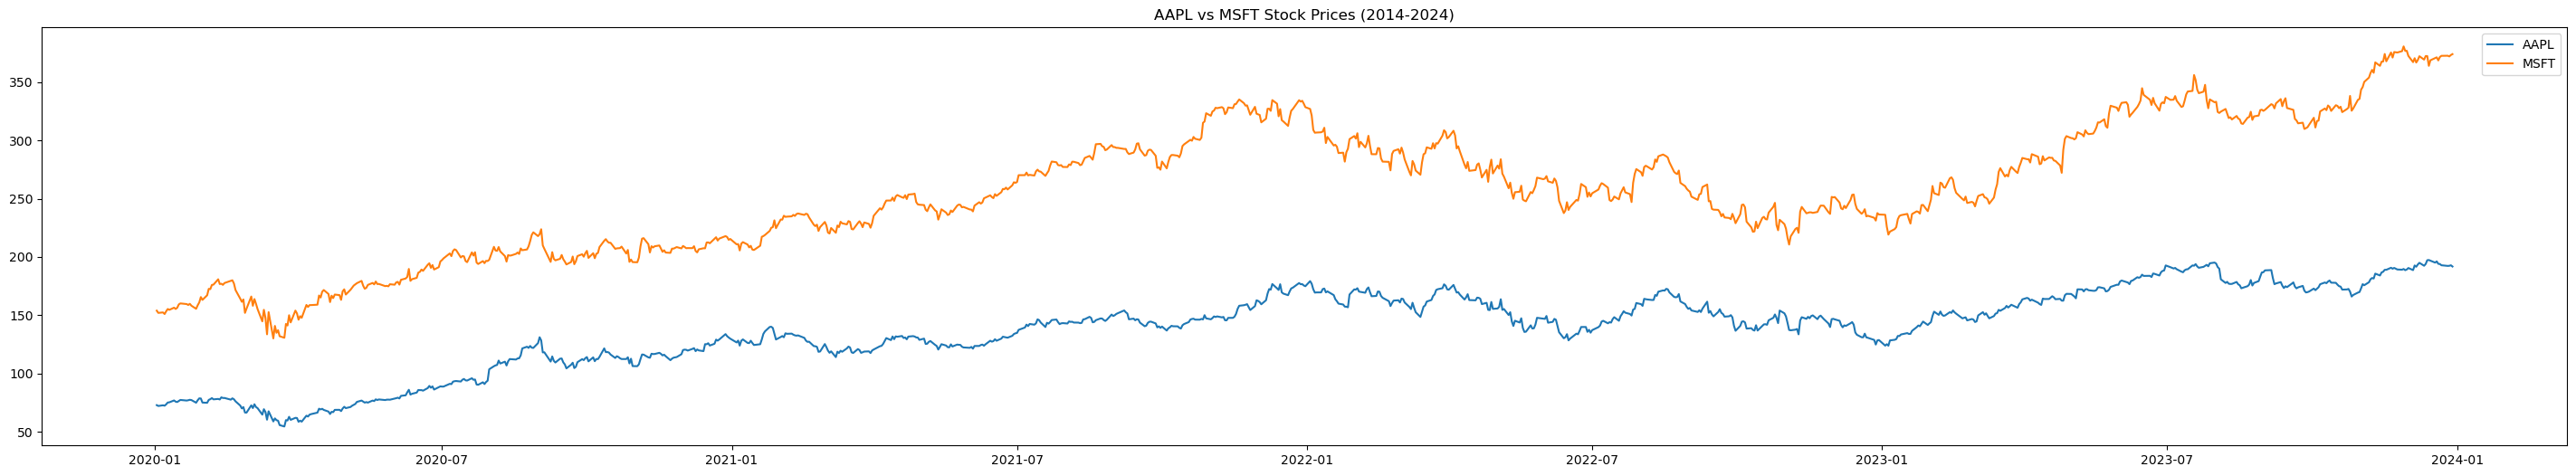

In [15]:
# Download stock data for AAPL and MSFT from 2020 to 2024
aapl_data = yf.download("AAPL", start="2020-01-01", end="2024-01-01")
msft_data = yf.download("MSFT", start="2020-01-01", end="2024-01-01")

# Focus on adjusted closing price for both stocks
aapl_close = aapl_data['Adj Close']
msft_close = msft_data['Adj Close']

plt.figure(figsize=(36, 6))
plt.plot(aapl_close, label='AAPL')
plt.plot(msft_close, label='MSFT')
plt.title('AAPL vs MSFT Stock Prices (2014-2024)')
plt.legend()
plt.show()

### 2. Check for Cointegration

Before implementing the pairs trading strategy, you need to ensure that the two stocks are **cointegrated**.

Cointegration is a statistical property where two non-stationary time series (such as stock prices) have a stationary linear combination. This suggests that they share a long-term equilibrium relationship, even if they diverge in the short term.

The p-value is the key output of the cointegration test.
* If the p-value is below a certain threshold (commonly 0.05), we reject the null hypothesis of no cointegration, meaning the series are cointegrated.
* If the p-value is above the threshold, we accept the null hypothesis, meaning the series are not cointegrated.

Null and Alternative Hypotheses:
* Null Hypothesis ($H_0$): There is no cointegration between the time series (the spread is not stationary)
* Alternative Hypothesis ($H_1$): There is cointegration between the time series (the spread is stationary)

We can perform the Engle-Granger test in Python using the `coint` function from `statsmodels`.

In [11]:
score, p_value, _ = coint(aapl_close, msft_close)
print(f"Cointegration Test p-value: {p_value}")

Cointegration Test p-value: 0.22061659756985152


The p-value is 0.22062 (5 d.p.), which would mean that the null hypothesis should be accepted; however, we will still proceed with the strategy for the sake of exploring its logic.

### 3. Calculate the Spread and Hedge Ratio

The **hedge ratio** tells us how much of MSFT we should buy or sell relative to AAPL to create a market-neutral position. We calculate the **hedge** ratio between the two stocks using **linear regression**.

In [13]:
# Perform linear regression (AAPL ~ MSFT)
X = sm.add_constant(msft_close)
model = sm.OLS(aapl_close, X).fit()

# Extract hedge ratio and intercept
hedge_ratio = model.params.iloc[1]
intercept = model.params.iloc[0]

The **spread** is the difference between the actual price of AAPL and its "predicted" price based on MSFT and the hedge ratio. When the spread deviates significantly from zero, it signals that the stocks are diverging, which may create a trading opportunity. We calculate the spread using the hedge ratio.

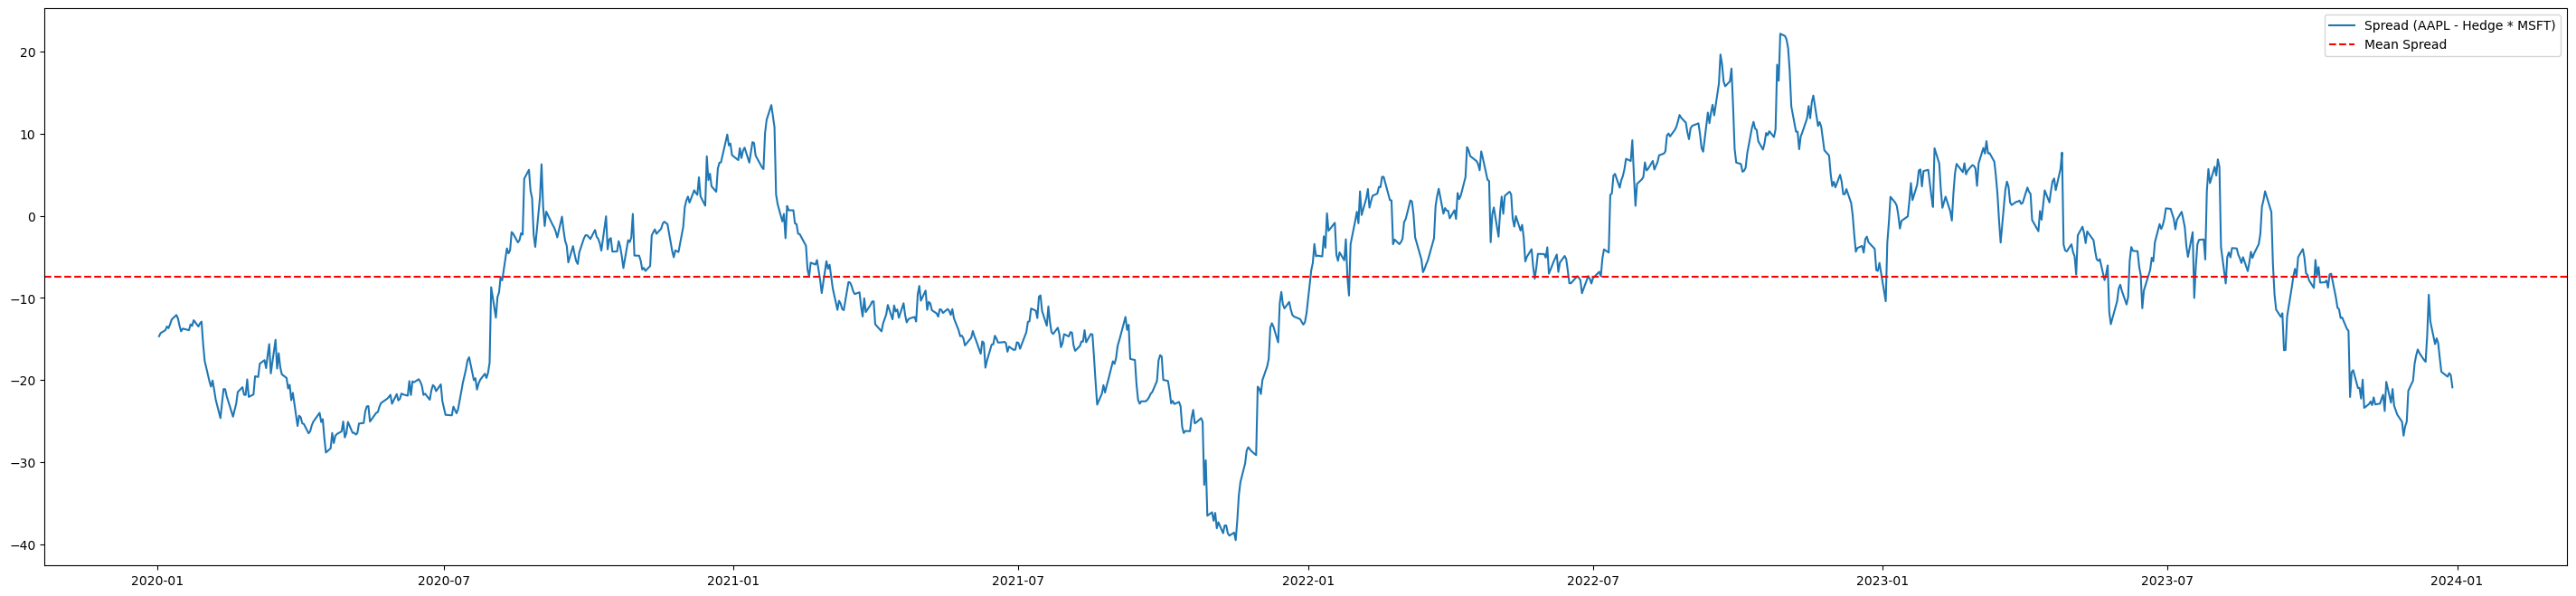

In [16]:
# Calculate spread
spread = aapl_close - hedge_ratio * msft_close

# Plot spread
plt.figure(figsize=(36, 8))
plt.plot(spread, label='Spread (AAPL - Hedge * MSFT)')
plt.axhline(spread.mean(), color='red', linestyle='--', label='Mean Spread')
plt.legend()
plt.show()

### 4. Calculate Bollinger Bands for Mean Reversion


A simple pairs trading strategy is to go long the spread when it is below a certain threshold (_i.e._, the spread is too negative) and go short when it is above a threshold.

**Bollinger Bands** provide a useful way to define potential entry and exit points in a pairs trading strategy by identifying whether the spread between two cointegrated stocks is moving beyond its typical range. They consist of:

* Middle Band: Usually a simple moving average (SMA) of the spread.
* Upper Band: The SMA plus two standard deviations of the spread.
* Lower Band: The SMA minus two standard deviations of the spread.

When the spread crosses the upper band, it suggests an opportunity to **short** AAPL and **buy** MSFT (expecting convergence). Conversely, when the spread crosses the lower band, it suggests an opportunity to **buy** AAPL and **short** MSFT.

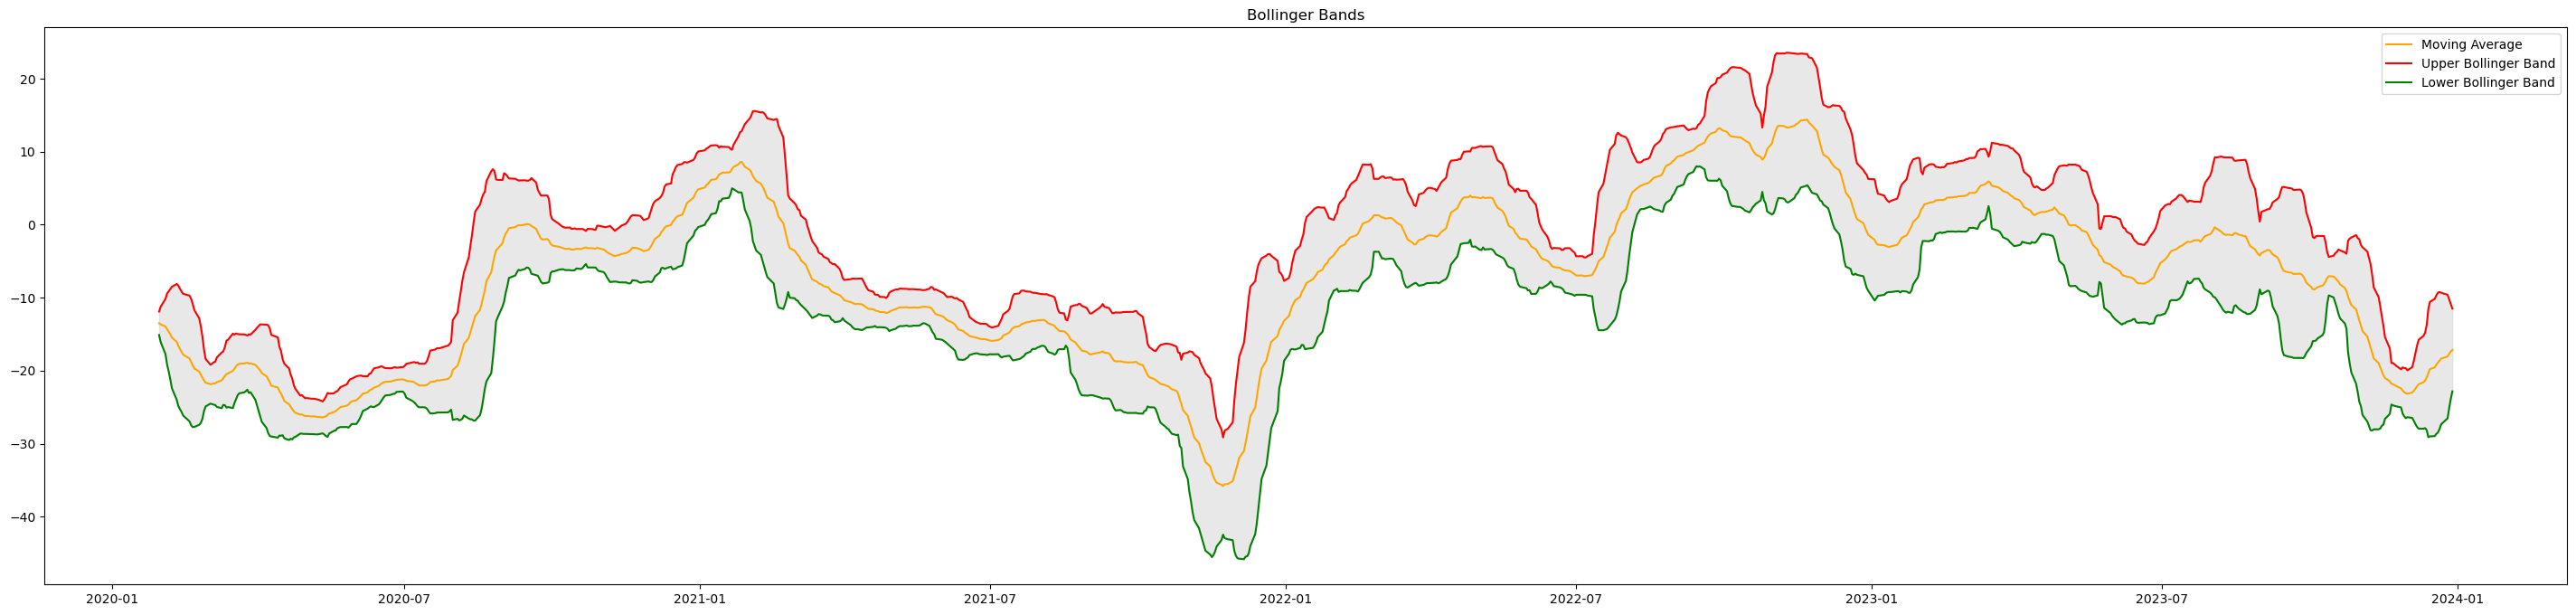

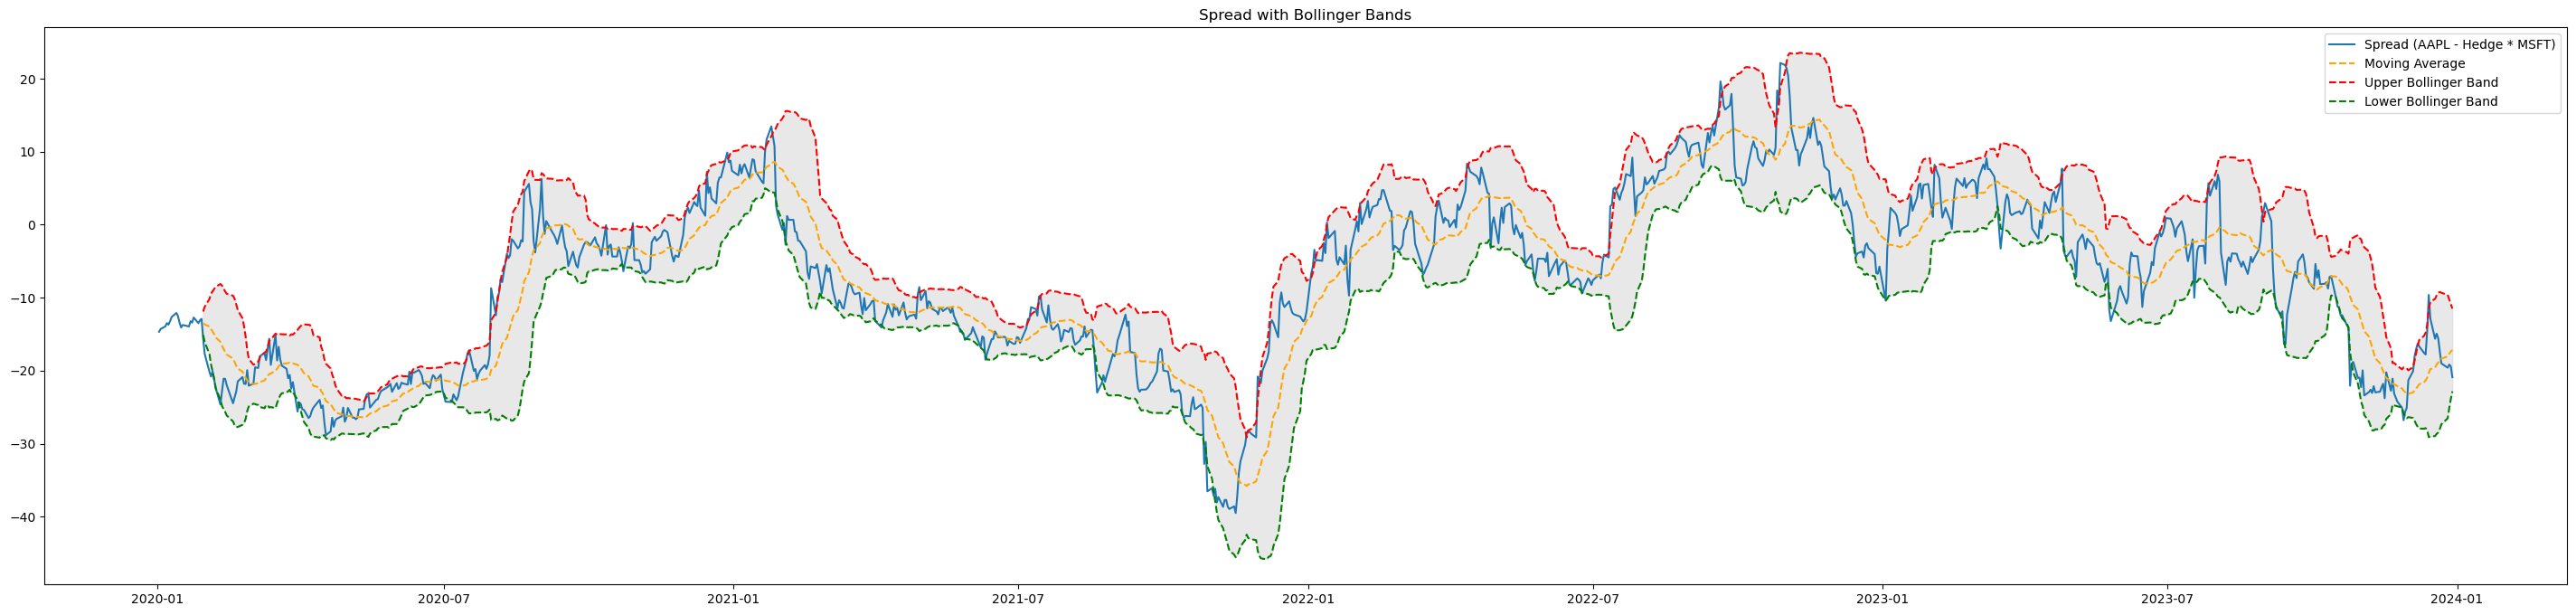

In [24]:
window = 20 

# Calculate moving average and standard deviation
rolling_mean = spread.rolling(window).mean()
rolling_std = spread.rolling(window).std()

# Calculate Bollinger Bands
upper_band = rolling_mean + (2 * rolling_std)
lower_band = rolling_mean - (2 * rolling_std)


# Plot Bollinger Bands
plt.figure(figsize=(36, 8))

plt.plot(rolling_mean, label='Moving Average', color='orange')
plt.plot(upper_band, label='Upper Bollinger Band', color='red')
plt.plot(lower_band, label='Lower Bollinger Band', color='green')

plt.fill_between(spread.index, upper_band, lower_band, color='lightgray', alpha=0.5)

plt.title('Bollinger Bands')
plt.legend()

plt.show()


# Plot Bollinger Bands with Spread
plt.figure(figsize=(36, 8))

plt.plot(spread, label='Spread (AAPL - Hedge * MSFT)')
plt.plot(rolling_mean, label='Moving Average', color='orange', linestyle='--')
plt.plot(upper_band, label='Upper Bollinger Band', color='red', linestyle='--')
plt.plot(lower_band, label='Lower Bollinger Band', color='green', linestyle='--')

plt.fill_between(spread.index, upper_band, lower_band, color='lightgray', alpha=0.5)

plt.title('Spread with Bollinger Bands')
plt.legend()

plt.show()

### 5. Generate Trading Signals

The core of the strategy is generating trading signals based on the spread's relationship to the Bollinger Bands. There are three signals that are generated:
* **Long signal**: When the spread falls below the lower Bollinger Band.
* **Short signal**: When the spread rises above the upper Bollinger Band.
* **Exit signal**: When the spread reverts back to the rolling mean.

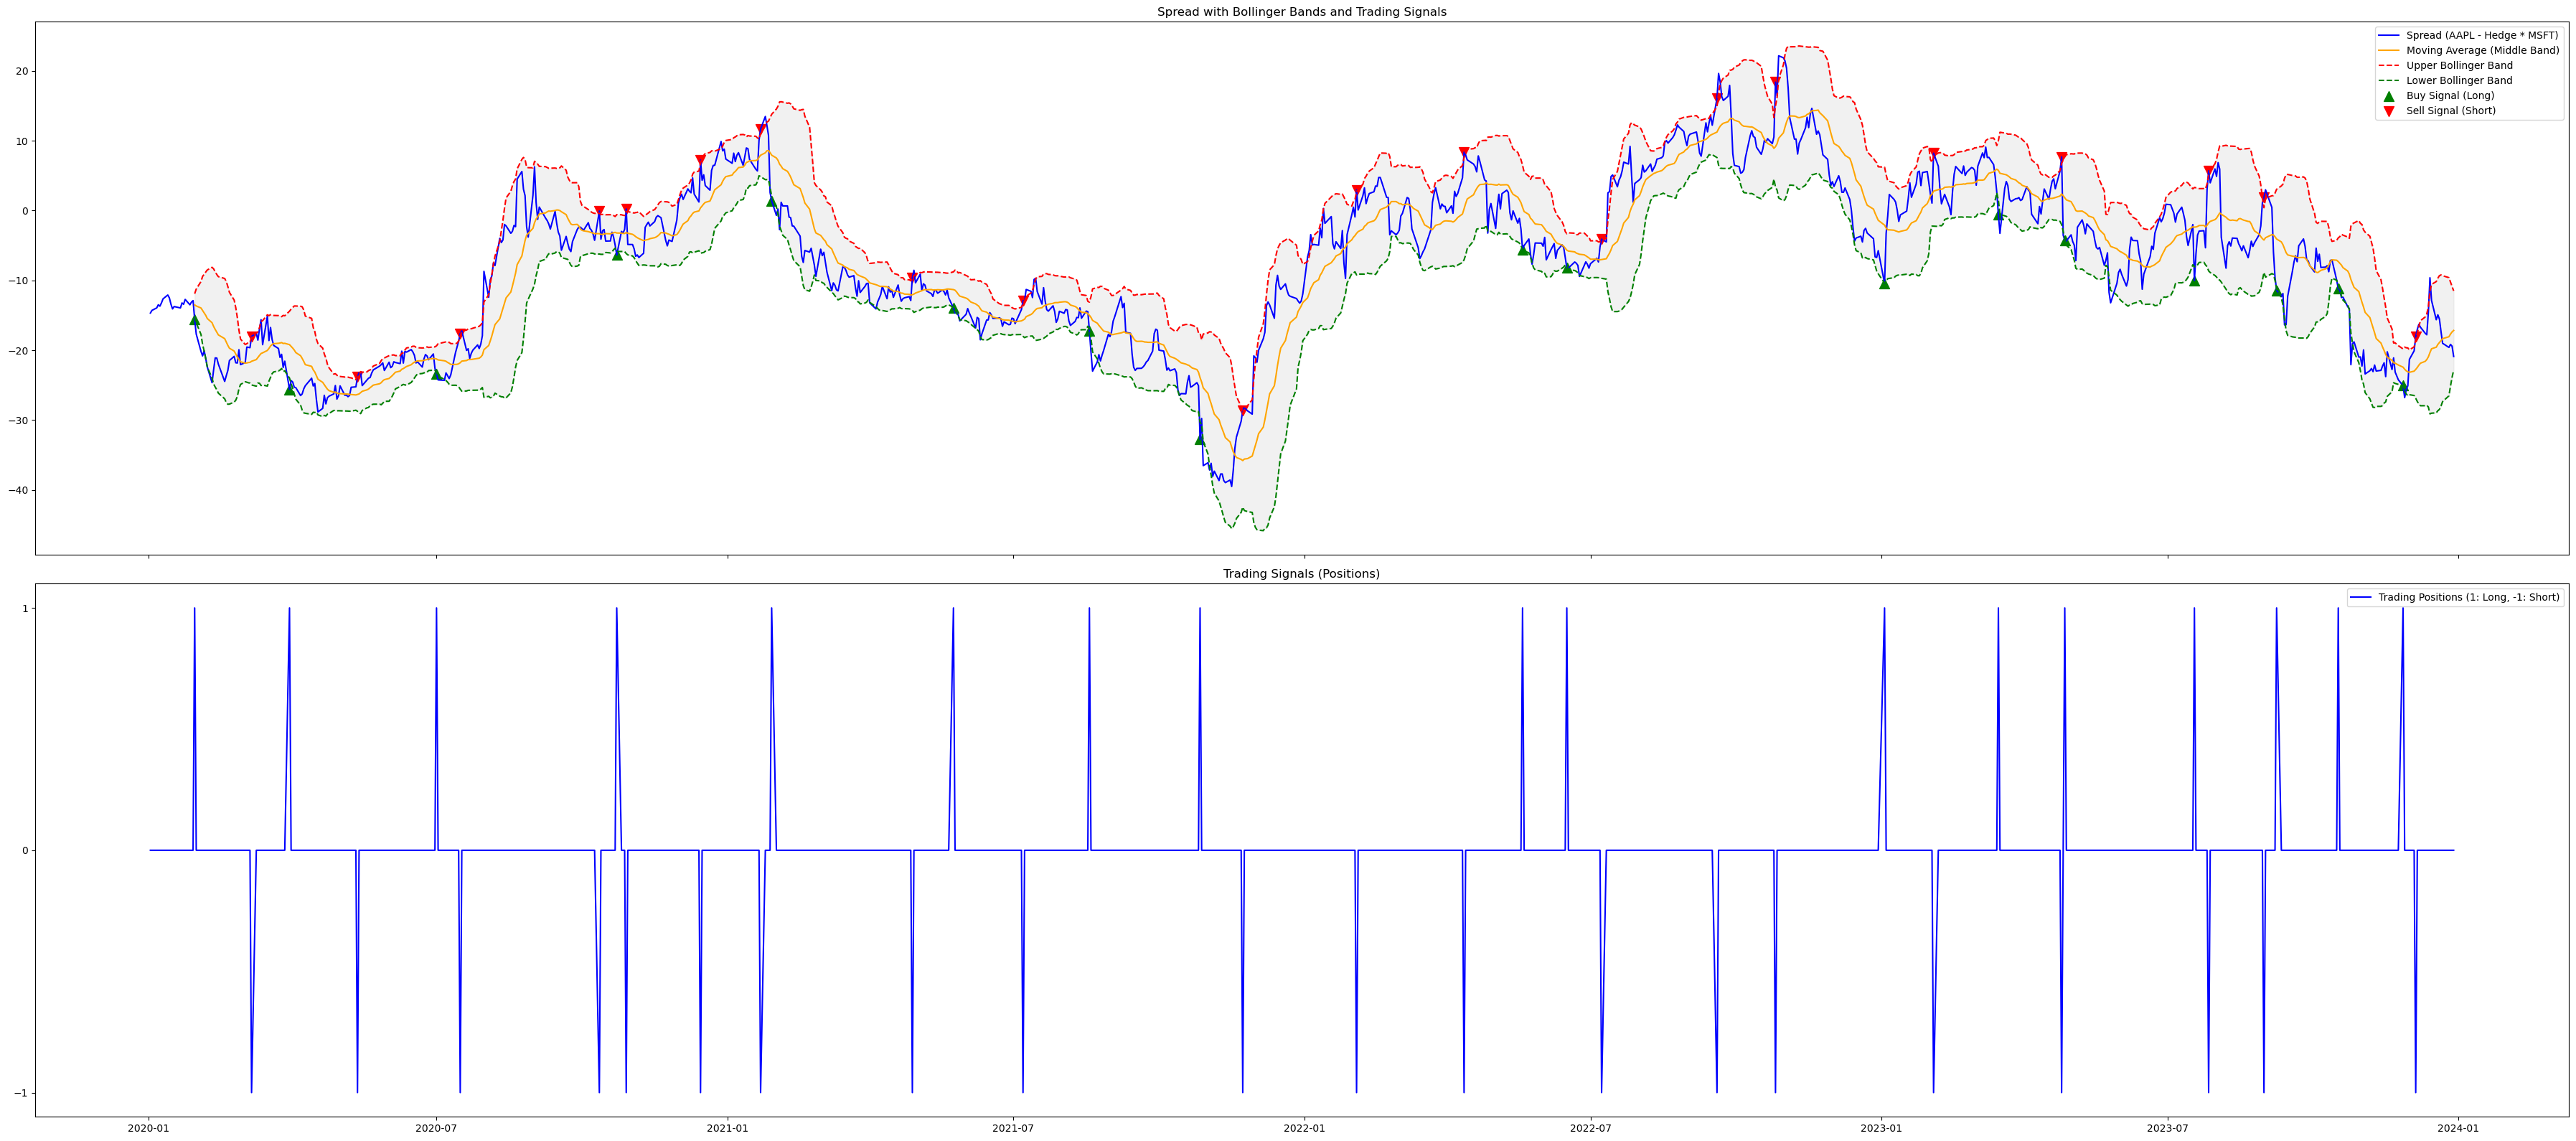

In [28]:
# Initialise signals DataFrame
signals = pd.DataFrame(index=spread.index)
signals['spread'] = spread
signals['positions'] = 0

# Variable to track state
current_position = 0  # 0 = no active position; 1 = long; -1 = short

# Loop through the spread to generate trading signals
for i in range(1, len(spread)):
    # If no position is currently held
    if current_position == 0:
        # Generate long signal if spread falls below the lower band
        if spread.iloc[i] < lower_band.iloc[i]:
            signals.loc[signals.index[i], 'positions'] = 1  # Long position
            current_position = 1  # Set current position to long
            
        # Generate short signal if spread rises above the upper band
        elif spread.iloc[i] > upper_band.iloc[i]:
            signals.loc[signals.index[i], 'positions'] = -1  # Short position
            current_position = -1  # Set current position to short
    
    # If a long or short position is held, exit when the spread returns to the mean
    elif current_position == 1 and spread.iloc[i] >= rolling_mean.iloc[i]:
        signals.loc[signals.index[i], 'positions'] = 0  # Exit long position
        current_position = 0  # Reset current position to no position
        
    elif current_position == -1 and spread.iloc[i] <= rolling_mean.iloc[i]:
        signals.loc[signals.index[i], 'positions'] = 0  # Exit short position
        current_position = 0  # Reset current position to no position

# Fill forward 'positions' to reflect position until it changes
signals['positions'] = signals['positions'].ffill().fillna(0)


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(36, 16), sharex=True)

# Plot the spread with Bollinger Bands on the first axis (ax1)
ax1.plot(spread, label='Spread (AAPL - Hedge * MSFT)', color='blue')
ax1.plot(rolling_mean, label='Moving Average (Middle Band)', color='orange')
ax1.plot(upper_band, label='Upper Bollinger Band', color='red', linestyle='--')
ax1.plot(lower_band, label='Lower Bollinger Band', color='green', linestyle='--')

ax1.fill_between(spread.index, lower_band, upper_band, color='lightgray', alpha=0.3)

ax1.scatter(spread[signals['positions'] == 1].index, spread[signals['positions'] == 1], 
            marker='^', color='green', label='Buy Signal (Long)', s=100)
ax1.scatter(spread[signals['positions'] == -1].index, spread[signals['positions'] == -1], 
            marker='v', color='red', label='Sell Signal (Short)', s=100)

ax1.set_title('Spread with Bollinger Bands and Trading Signals')
ax1.legend()


# Plot the trading positions on the second axis (ax2)
ax2.plot(signals['positions'], label='Trading Positions (1: Long, -1: Short)', color='blue')

ax2.set_yticks([1, 0, -1])
ax2.set_title('Trading Signals (Positions)')
ax2.legend()

plt.tight_layout()
plt.show()


### 6. Backtest the Strategy

Finally, we calculate the returns based on the positions generated and assess the performance of the strategy. The cumulative returns show the effectiveness of the pairs trading strategy over time.

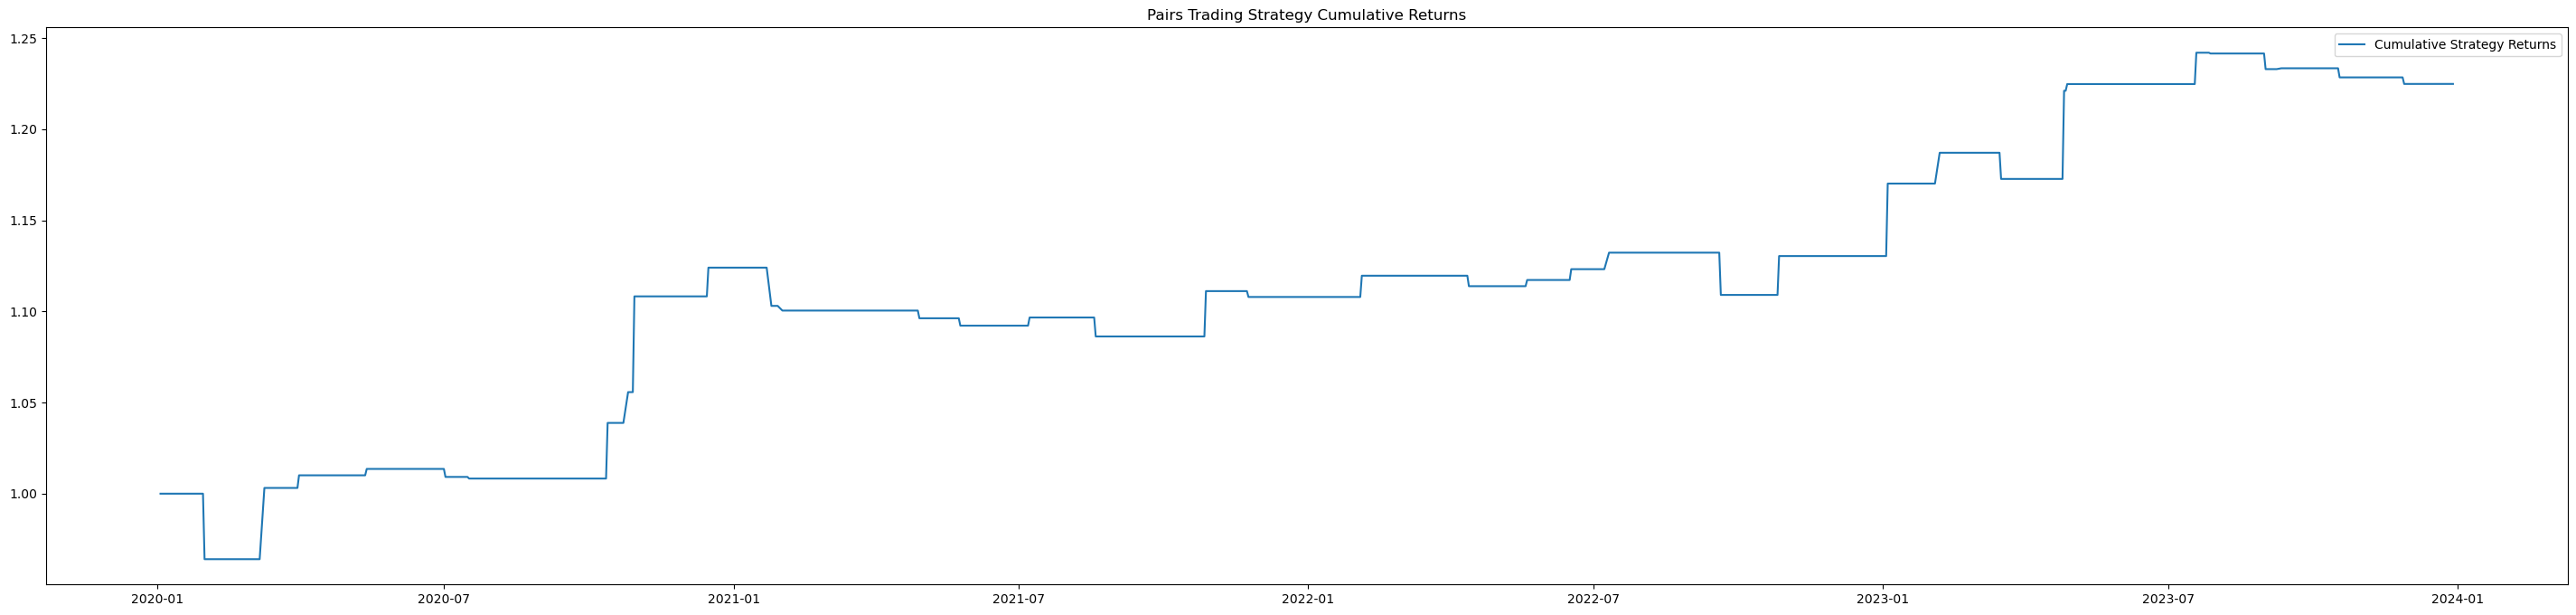

In [29]:
# Calculate returns for AAPL and MSFT
aapl_returns = aapl_close.pct_change().dropna()
msft_returns = msft_close.pct_change().dropna()

# Calculate the strategy returns based on the hedge ratio
strategy_returns = signals['positions'].shift(1) * (aapl_returns - hedge_ratio * msft_returns)

# Calculate cumulative returns
cumulative_returns = (1 + strategy_returns).cumprod()

# Plot the cumulative returns
plt.figure(figsize=(36, 8))
plt.plot(cumulative_returns, label='Cumulative Strategy Returns')
plt.title('Pairs Trading Strategy Cumulative Returns')
plt.legend()
plt.show()